In [1]:
import numpy
import scipy.stats
import py_monte_carlo
from matplotlib import pyplot
import pickle
import os

In [2]:
side_len = 6
nvars = side_len*side_len

x = numpy.arange(side_len)
y = x
X, Y = numpy.meshgrid(x, y)

INDX = Y*side_len + X
RIGHT = Y*side_len + (X+1)%side_len
BOT = (((Y+1) % side_len )*side_len + X)

right_edges = [((a, b), -1.0) for a, b in zip(INDX.flatten(), RIGHT.flatten())]
bot_edges = [((a, b), -1.0 if b%2 else 1.0) for a, b in zip(INDX.flatten(), BOT.flatten())]

edges =  right_edges + bot_edges

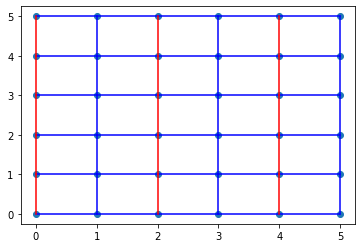

In [3]:
pyplot.scatter(X.flatten(), Y.flatten())
for (a,b),j in edges:
    c = 'b'
    if j > 0:
        c = 'r'
    ax = a % side_len
    ay = a // side_len
    bx = b % side_len
    by = b // side_len
    if abs(bx - ax) <= 1 and abs(by - ay) <= 1: 
        pyplot.plot([ax, bx], [ay, by], c)
    else:
        pass
        #pyplot.plot(xs, ys, c+'--')

In [4]:
def parallel(a, b):
    ax, ay = a
    bx, by = b
    dx = bx - ax
    dy = by - ay
    ny = (by + dy) % side_len
    nx = (bx + dx) % side_len
    return (bx, by), (nx, ny)

def plot_state(state):
    edge_gen = ((state[a] ^ state[b],j) for (a,b), j in edges)
    dimer_states = [a if j<0 else not a for a,j in edge_gen]
    all_indices = numpy.asarray([(a,b) for (a,b),_ in edges])
    x_all_indices = all_indices % side_len
    y_all_indices = all_indices // side_len
    all_coords = numpy.dstack([x_all_indices, y_all_indices])
    dimer_lookup = dict(((tuple(a), tuple(b)), s) for (a,b), s in zip(all_coords, dimer_states))
    
    pyplot.scatter(X.flatten(), Y.flatten())
    for k,v in dimer_lookup.items():
        c = 'b'
        if v:
            c = 'r'
        a, b = k
        xs, ys = zip(a, b)
        
        xs = list(xs)
        ys = list(ys)
        if abs(xs[0] - xs[1]) > 1:
            xs[0] = max(xs[0], xs[1])
            xs[1] = xs[0] + 1
        if abs(ys[0] - ys[1]) > 1: 
            ys[0] = min(ys[0], ys[1]) - 1
            ys[1] = ys[0] + 1
        
        avg_x = sum(xs)/2.0
        avg_y = sum(ys)/2.0

        if xs[0] == xs[1]:
            pyplot.plot([avg_x-0.5, avg_x+0.5], [avg_y,avg_y], c)
        else:
            pyplot.plot([avg_x, avg_x], [avg_y-0.5,avg_y+0.5], c)
        
    pyplot.show()
    
    tot = 0
    count = 0
    for k in filter(lambda k: dimer_lookup[k], dimer_lookup):
        tot += 1
        if dimer_lookup[parallel(*k)]:
            count += 1
    return (tot, count)

Create an initial columnar state

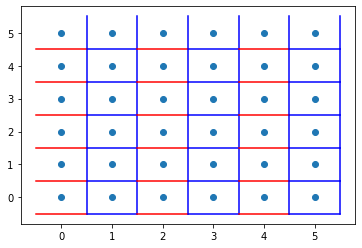

(18, 18)

In [5]:
plot_state([True for _ in range(nvars)])

In [10]:
def get_linearish(data, window=20):
    lowest_err = (0,0,1e512, 0)
    i = 0
    while i < len(data)-window:
        subdat = data[i:i+window]
        if any(numpy.isnan(subdat)):
            i += window
        else:
            slope, intercept, _, _, std_err = scipy.stats.linregress(range(i, i+window), subdat)
            if std_err < lowest_err[2]:
                lowest_err = (slope, intercept, std_err, i)
            i += 1
    return lowest_err

In [6]:
graph = py_monte_carlo.Lattice(edges)
graph.set_initial_state([True for _ in range(nvars)])

In [23]:
hs = numpy.linspace(0.1, 2.0, 20)
betas = numpy.linspace(0.1, 10.0, 20)

HS, BETAS = numpy.meshgrid(hs, betas)

In [ ]:
if not os.path.exists('corrs'):
    os.mkdir('corrs')
    

@numpy.vectorize
def run_corrs(h, beta):
    filename = 'corrs/{}'.format(hash((h, beta)))
    if os.path.exists(filename):
        with open(filename, 'rb') as f:
            bond_correlation = pickle.load(f)
    else:
        graph.set_transverse_field(1.0)
        bond_correlation = numpy.mean(numpy.asarray(graph.run_quantum_monte_carlo_and_measure_bond_autocorrelation(beta, 1000, 16)), axis=0)
        with open(filename, 'wb') as w:
            pickle.dump(bond_correlation, w)
    slope, _, _, _ = get_linearish(bond_correlation[:100], window=20)
    return slope
    
correlations = run_corrs(HS, BETAS)

In [ ]:
pyplot.imshow(correlations)
pyplot.show()